# Описание задания

Основная задача - выбрать и решить соревнование с платформы Kaggle.com  (http://kaggle.com/) , используя два подхода:
1. Подготовить базовое решение (бейзлайн) с помощью Light Auto ML (LAMA)
2. Реализовать альтернативное решение без использования LAMA

Требования к выбору соревнования
- Можно выбрать как текущие, так и прошедшие денежные соревнования
- Другие типы соревнований необходимо согласовать с куратором курса
- Нельзя использовать простые соревнования типа Titanic

Цели проекта
- Превзойти результаты бейзлайна на LAMA
- Продемонстрировать качественный код
- Использовать стандартные подходы к организации кода (например, Pipeline)
- Провести качественный EDA
- Предоставить подробное описание и обоснование гипотез

# Анализ данных

Этот ноутбук содержит полный анализ данных соревнования IEEE-CIS Fraud Detection.

Содержание:
1. Загрузка и обзор данных
2. Анализ целевой переменной
3. Анализ признаков
4. Анализ пропущенных значений
5. Корреляционный анализ
6. Генерация гипотез для feature engineering

In [1]:
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
from utils import (
    load_data, 
    get_feature_types, 
    calculate_missing_stats
)

In [3]:
from pathlib import Path
from dataclasses import dataclass
from typing import List

DATA_DIR = Path("data")
SUBMISSIONS_DIR = Path("submissions")
REPORTS_DIR = Path("reports")

for dir_path in [DATA_DIR, SUBMISSIONS_DIR, REPORTS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

In [21]:
@dataclass
class FeatureConfig:
    """Конфигурация признаков датасета"""
    cat_transaction = None
    cat_identity = None
    target = "isFraud"
    id_col = "TransactionID"
    time_col = "TransactionDT"

FEATURE_CONFIG = FeatureConfig()

In [5]:
train, test, sample_sub = load_data(DATA_DIR)

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Sample submission shape: {sample_sub.shape}")

print(f"Количество строк: {len(train):,}")
print(f"Количество признаков: {train.shape[1]}")
print(f"Первые 5 строк:")
train.head()

Train shape: (590540, 434), Test shape: (506691, 433)
Train shape: (590540, 434)
Test shape: (506691, 433)
Sample submission shape: (506691, 2)
Количество строк: 590,540
Количество признаков: 434
Первые 5 строк:


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500,W,13926,NaN,150.000,discover,142.000,credit,315.000,87.000,19.000,NaN,NaN,NaN,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,2.000,0.000,1.000,1.000,14.000,NaN,13.000,NaN,NaN,NaN,NaN,NaN,NaN,13.000,13.000,NaN,NaN,NaN,0.000,T,T,T,M2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000,W,2755,404.000,150.000,mastercard,102.000,credit,325.000,87.000,NaN,NaN,gmail.com,NaN,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,M0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.000,W,4663,490.000,150.000,visa,166.000,debit,330.000,87.000,287.000,NaN,outlook.com,NaN,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,0.000,315.000,NaN,NaN,NaN,315.000,T,T,T,M0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.000,W,18132,567.000,150.000,mastercard,117.000,debit,476.000,87.000,NaN,NaN,yahoo.com,NaN,2.000,5.000,0.000,0.000,0.000,4.000,0.000,0.000,1.000,0.000,1.000,0.000,25.000,1.000,112.000,112.000,0.000,94.000,0.000,NaN,NaN,NaN,NaN,84.000,NaN,NaN,NaN,NaN,111.000,NaN,NaN,NaN,M0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.000,H,4497,514.000,150.000,mastercard,102.000,credit,420.000,87.000,NaN,NaN,gmail.com,NaN,1.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,1.000,1.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,70787.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000,NotFound,NaN,-480.000,New,NotFound,166.000,NaN,542.000,144.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.000,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [6]:
print("Типы данных:")
print(train.dtypes.value_counts())

Типы данных:
float64    399
object      31
int64        4
Name: count, dtype: int64


## Анализ целевой переменной

In [7]:
# Распределение целевой переменной
target = FEATURE_CONFIG.target

fraud_counts = train[target].value_counts()
fraud_pct = train[target].value_counts(normalize=True) * 100

print(f"Распределение классов:")
print(f"Не мошенничество (0): {fraud_counts[0]:} ({fraud_pct[0]:.2f}%)")
print(f"Мошенничество (1):    {fraud_counts[1]:} ({fraud_pct[1]:.2f}%)")
print(f"Дисбаланс классов:    1:{fraud_counts[0]/fraud_counts[1]:.0f}")

Распределение классов:
Не мошенничество (0): 569877 (96.50%)
Мошенничество (1):    20663 (3.50%)
Дисбаланс классов:    1:28


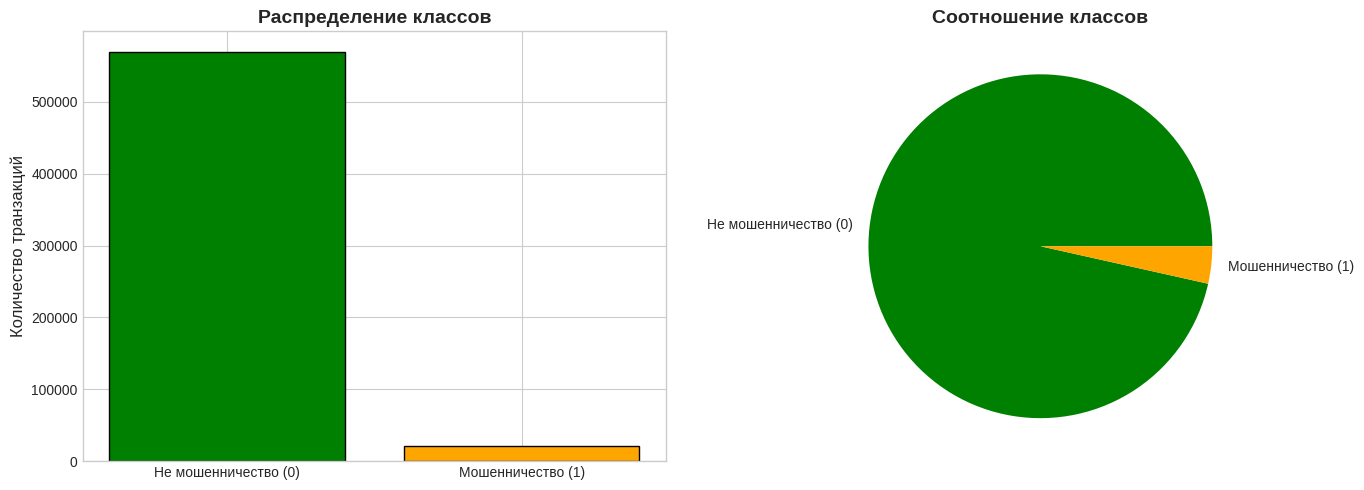

In [8]:
# Визуализация распределения целевой переменной
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['green', 'orange']
ax1 = axes[0]
bars = ax1.bar(
    ['Не мошенничество (0)', 'Мошенничество (1)'], 
    fraud_counts.values, color=colors, edgecolor='black'
)
ax1.set_ylabel('Количество транзакций', fontsize=12)
ax1.set_title('Распределение классов', fontsize=14, fontweight='bold')

# Pie chart
ax2 = axes[1]
ax2.pie(
    fraud_counts.values, labels=['Не мошенничество (0)', 'Мошенничество (1)'], colors=colors
)
ax2.set_title('Соотношение классов', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(DATA_DIR.parent / 'reports' / 'target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

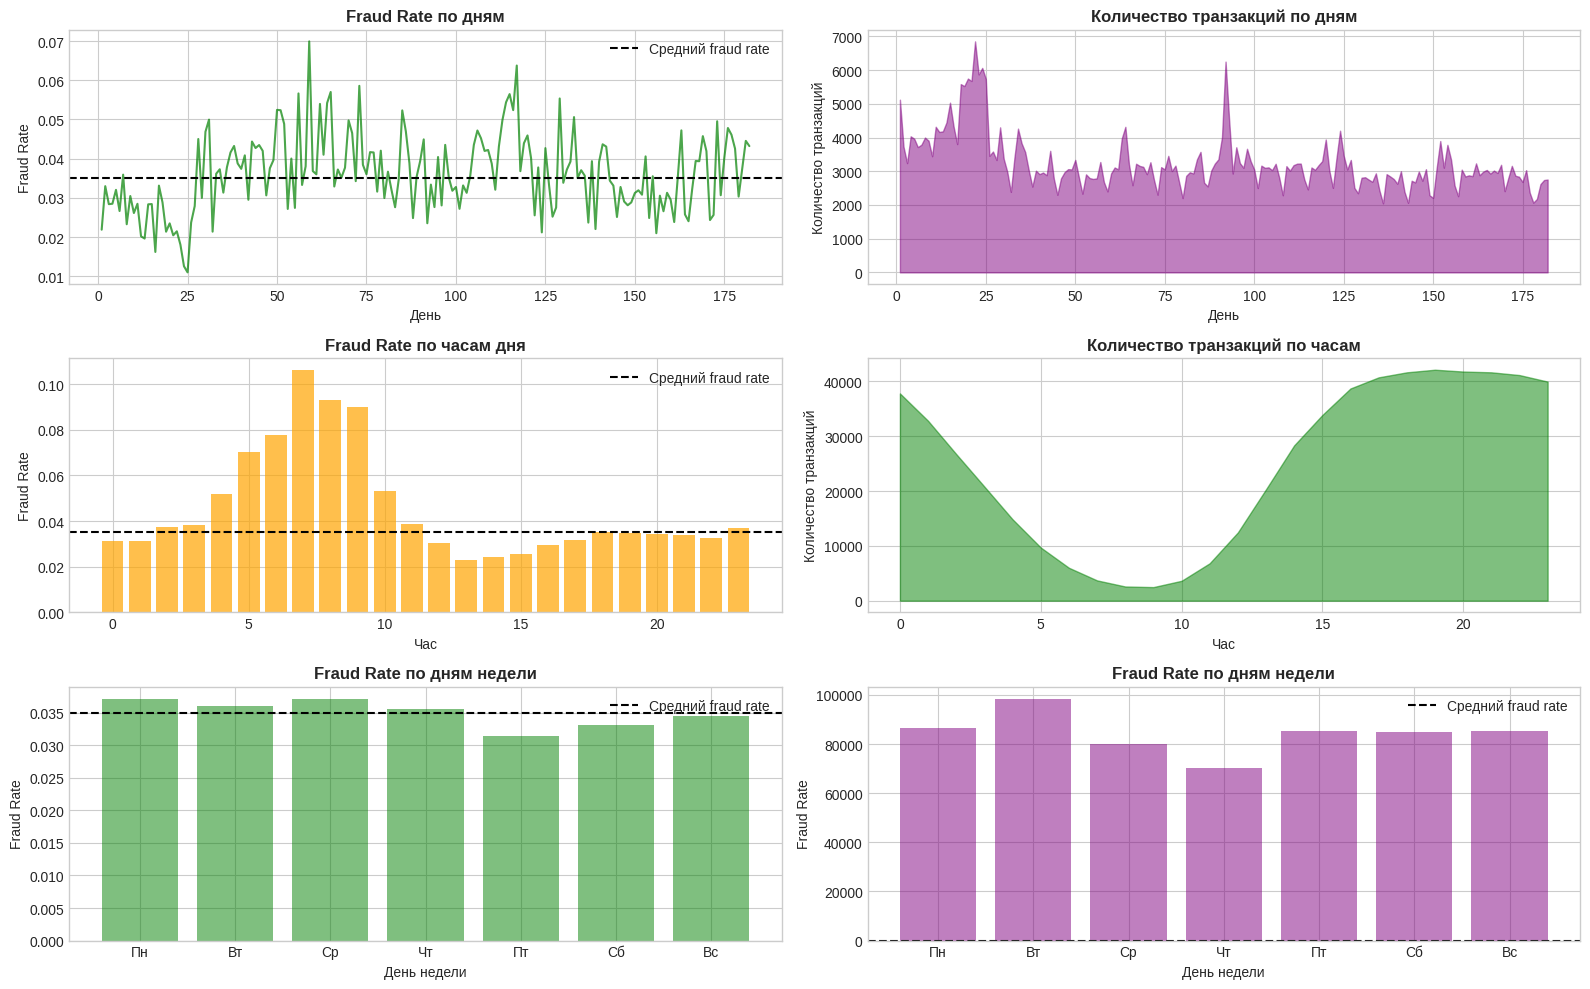

In [9]:
# Анализ целевой переменной во времени
fig, axes = plt.subplots(3, 2, figsize=(16, 10))

# Fraud rate по дням
train['day'] = train['TransactionDT'] // (24 * 3600)
daily_fraud = train.groupby('day')[target].agg(['sum', 'count', 'mean'])
daily_fraud.columns = ['fraud_count', 'total_count', 'fraud_rate']

ax1 = axes[0, 0]
ax1.plot(daily_fraud.index, daily_fraud['fraud_rate'], color='green', alpha=0.7)
ax1.axhline(y=train[target].mean(), color='black', linestyle='--', label='Средний fraud rate')
ax1.set_xlabel('День')
ax1.set_ylabel('Fraud Rate')
ax1.set_title('Fraud Rate по дням', fontsize=12, fontweight='bold')
ax1.legend()

# Количество транзакций по дням
ax2 = axes[0, 1]
ax2.fill_between(daily_fraud.index, daily_fraud['total_count'], alpha=0.5, color='purple')
ax2.set_xlabel('День')
ax2.set_ylabel('Количество транзакций')
ax2.set_title('Количество транзакций по дням', fontsize=12, fontweight='bold')

# Fraud rate по часам
train['hour'] = (train['TransactionDT'] // 3600) % 24
hourly_fraud = train.groupby('hour')[target].agg(['sum', 'count', 'mean'])
hourly_fraud.columns = ['fraud_count', 'total_count', 'fraud_rate']

ax3 = axes[1, 0]
bars = ax3.bar(hourly_fraud.index, hourly_fraud['fraud_rate'], color='orange', alpha=0.7)
ax3.axhline(y=train[target].mean(), color='black', linestyle='--', label='Средний fraud rate')
ax3.set_xlabel('Час')
ax3.set_ylabel('Fraud Rate')
ax3.set_title('Fraud Rate по часам дня', fontsize=12, fontweight='bold')
ax3.legend()

# Количество транзакций по часам
ax4 = axes[1, 1]
ax4.fill_between(hourly_fraud.index, hourly_fraud['total_count'], alpha=0.5, color='green')
ax4.set_xlabel('Час')
ax4.set_ylabel('Количество транзакций')
ax4.set_title('Количество транзакций по часам', fontsize=12, fontweight='bold')

# Fraud rate по дню недели
train['weekday'] = train['day'] % 7
weekday_fraud = train.groupby('weekday')[target].agg(['sum', 'count', 'mean'])
weekday_fraud.columns = ['fraud_count', 'total_count', 'fraud_rate']

ax5 = axes[2, 0]
weekday_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
ax5.bar(range(7), weekday_fraud["fraud_rate"], color='green', alpha=0.5)
ax5.set_xticks(range(7))
ax5.set_xticklabels(weekday_names)
ax5.axhline(y=train[target].mean(), color='black', linestyle='--', label='Средний fraud rate')
ax5.set_xlabel('День недели')
ax5.set_ylabel('Fraud Rate')
ax5.set_title('Fraud Rate по дням недели', fontsize=12, fontweight='bold')
ax5.legend()

ax6 = axes[2, 1]
ax6.bar(range(7), weekday_fraud["total_count"], color='purple', alpha=0.5)
ax6.set_xticks(range(7))
ax6.set_xticklabels(weekday_names)
ax6.axhline(y=train[target].mean(), color='black', linestyle='--', label='Средний fraud rate')
ax6.set_xlabel('День недели')
ax6.set_ylabel('Fraud Rate')
ax6.set_title('Fraud Rate по дням недели', fontsize=12, fontweight='bold')
ax6.legend()

plt.tight_layout()
plt.savefig(DATA_DIR.parent / 'reports' / 'target_time_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## Выводы по целевой переменной:

1. **Сильный дисбаланс классов**: ~3.5% мошеннических транзакций
2. **Временные паттерны**: в ночные часы транзакций значительно меньше, а Fraud Rate - выше
3. **Рекомендации**:
    - Использовать stratified split для валидации
    - Рассмотреть time-based split

## Анализ признаков

In [10]:
# Типизация признаков с использованием функции, автоматически определяющей тип данных
feature_types = get_feature_types(train, target)

Numeric: 395, Categorical: 33, Binary: 7


In [11]:
print(f"Числовые признаки: {len(feature_types['numeric'])}")
print(f"Категориальные признаки: {len(feature_types['categorical'])}")
print(f"Бинарные признаки: {len(feature_types['binary'])}")

Числовые признаки: 395
Категориальные признаки: 33
Бинарные признаки: 7


### Анализ числовых признаков

In [12]:
# Возьмем первые 30 признаков и посмотрим статистику

numeric_cols = feature_types['numeric'][:30]
numeric_stats = train[numeric_cols].describe().T
numeric_stats['missing_pct'] = (train[numeric_cols].isnull().sum() / len(train) * 100)

In [19]:
numeric_stats

,count,mean,std,min,25%,50%,75%,max,missing_pct
TransactionDT,590540.000,7372311.310,4617223.647,86400.000,3027057.750,7306527.500,11246620.000,15811131.000,0.000
TransactionAmt,590540.000,135.027,239.163,0.251,43.321,68.769,125.000,31937.391,0.000
card1,590540.000,9898.735,4901.170,1000.000,6019.000,9678.000,14184.000,18396.000,0.000
card2,581607.000,362.555,157.793,100.000,214.000,361.000,512.000,600.000,1.513
card3,588975.000,153.195,11.336,100.000,150.000,150.000,150.000,231.000,0.265
card5,586281.000,199.279,41.244,100.000,166.000,226.000,226.000,237.000,0.721
addr1,524834.000,290.734,101.741,100.000,204.000,299.000,330.000,540.000,11.126
addr2,524834.000,86.801,2.691,10.000,87.000,87.000,87.000,102.000,11.126
dist1,238269.000,118.502,371.872,0.000,3.000,8.000,24.000,10286.000,59.652
dist2,37627.000,231.855,529.053,0.000,7.000,37.000,206.000,11623.000,93.628


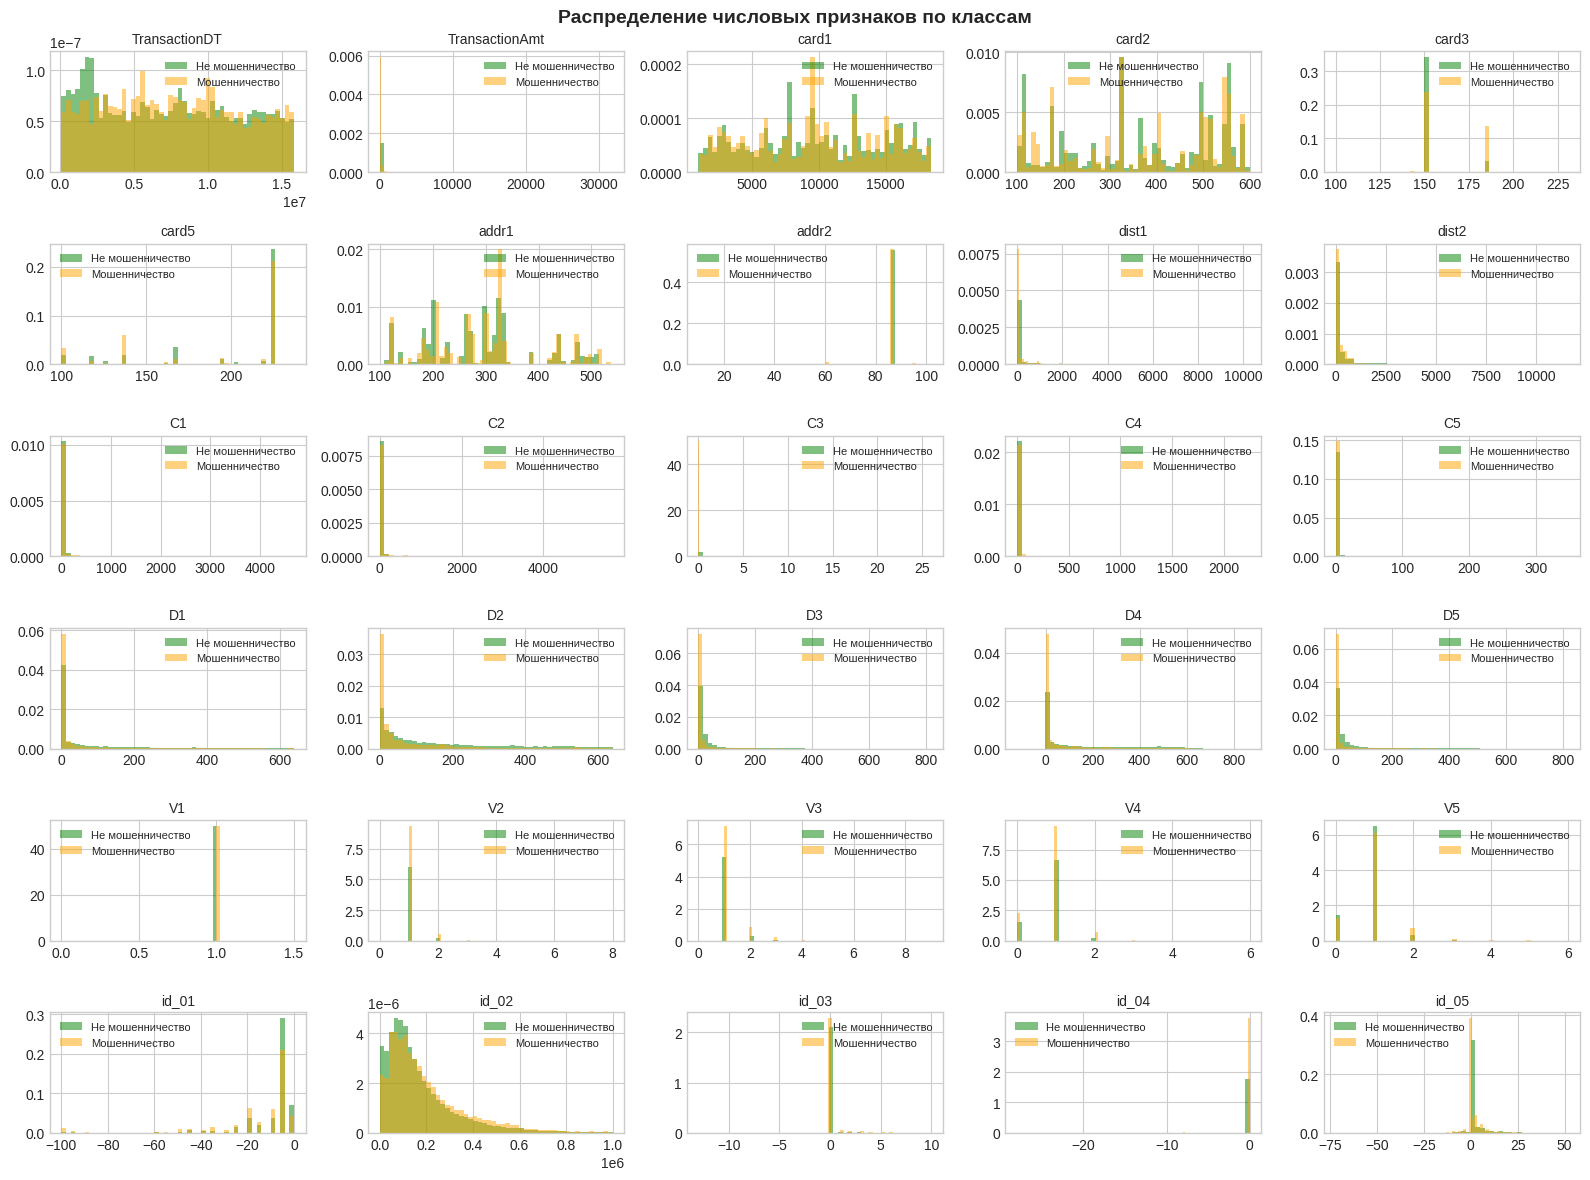

In [20]:
# Визуализация распределений числовых признаков
fig, axes = plt.subplots(6, 5, figsize=(16, 12))
axes = axes.flatten()

# Выбираем числовые признаки
important_numeric = [
    'TransactionDT', 'TransactionAmt',
    'card1', 'card2', 'card3', 'card5',
    'addr1', 'addr2', 'dist1', 'dist2',
    'C1', 'C2', 'C3', 'C4', 'C5',
    'D1', 'D2', 'D3', 'D4', 'D5', 
    'V1', 'V2', 'V3', 'V4', 'V5',
    'id_01', 'id_02', 'id_03', 'id_04', 'id_05'
]

for i, col in enumerate(important_numeric):
    if col in train.columns and i < len(axes):
        ax = axes[i]
        
        train[train[target] == 0][col].hist(ax=ax, alpha=0.5, label='Не мошенничество', 
                                             bins=50, density=True, color='green')
        train[train[target] == 1][col].hist(ax=ax, alpha=0.5, label='Мошенничество',
                                             bins=50, density=True, color='orange')
        ax.set_title(col, fontsize=10)
        ax.legend(fontsize=8)
        ax.set_ylabel('')

plt.suptitle('Распределение числовых признаков по классам', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(DATA_DIR.parent / 'reports' / 'numeric_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

### Анализ категориальных признаков

In [22]:
cat_cols = feature_types['categorical'] + feature_types['binary']

for col in cat_cols:
    if col in train.columns:
        nunique = train[col].nunique()
        missing_pct = train[col].isnull().mean() * 100
        print(f"{col}: {nunique} уникальных значений, {missing_pct:.1f}% пропусков")

ProductCD: 5 уникальных значений, 0.0% пропусков
card4: 4 уникальных значений, 0.3% пропусков
card6: 4 уникальных значений, 0.3% пропусков
P_emaildomain: 59 уникальных значений, 16.0% пропусков
R_emaildomain: 60 уникальных значений, 76.8% пропусков
M1: 2 уникальных значений, 45.9% пропусков
M2: 2 уникальных значений, 45.9% пропусков
M3: 2 уникальных значений, 45.9% пропусков
M4: 3 уникальных значений, 47.7% пропусков
M5: 2 уникальных значений, 59.3% пропусков
M6: 2 уникальных значений, 28.7% пропусков
M7: 2 уникальных значений, 58.6% пропусков
M8: 2 уникальных значений, 58.6% пропусков
M9: 2 уникальных значений, 58.6% пропусков
id_12: 2 уникальных значений, 75.6% пропусков
id_15: 3 уникальных значений, 76.1% пропусков
id_16: 2 уникальных значений, 78.1% пропусков
id_23: 3 уникальных значений, 99.1% пропусков
id_27: 2 уникальных значений, 99.1% пропусков
id_28: 2 уникальных значений, 76.1% пропусков
id_29: 2 уникальных значений, 76.1% пропусков
id_30: 75 уникальных значений, 86.9% пропу

In [23]:
len(feature_types['categorical'] + feature_types['binary'])

40

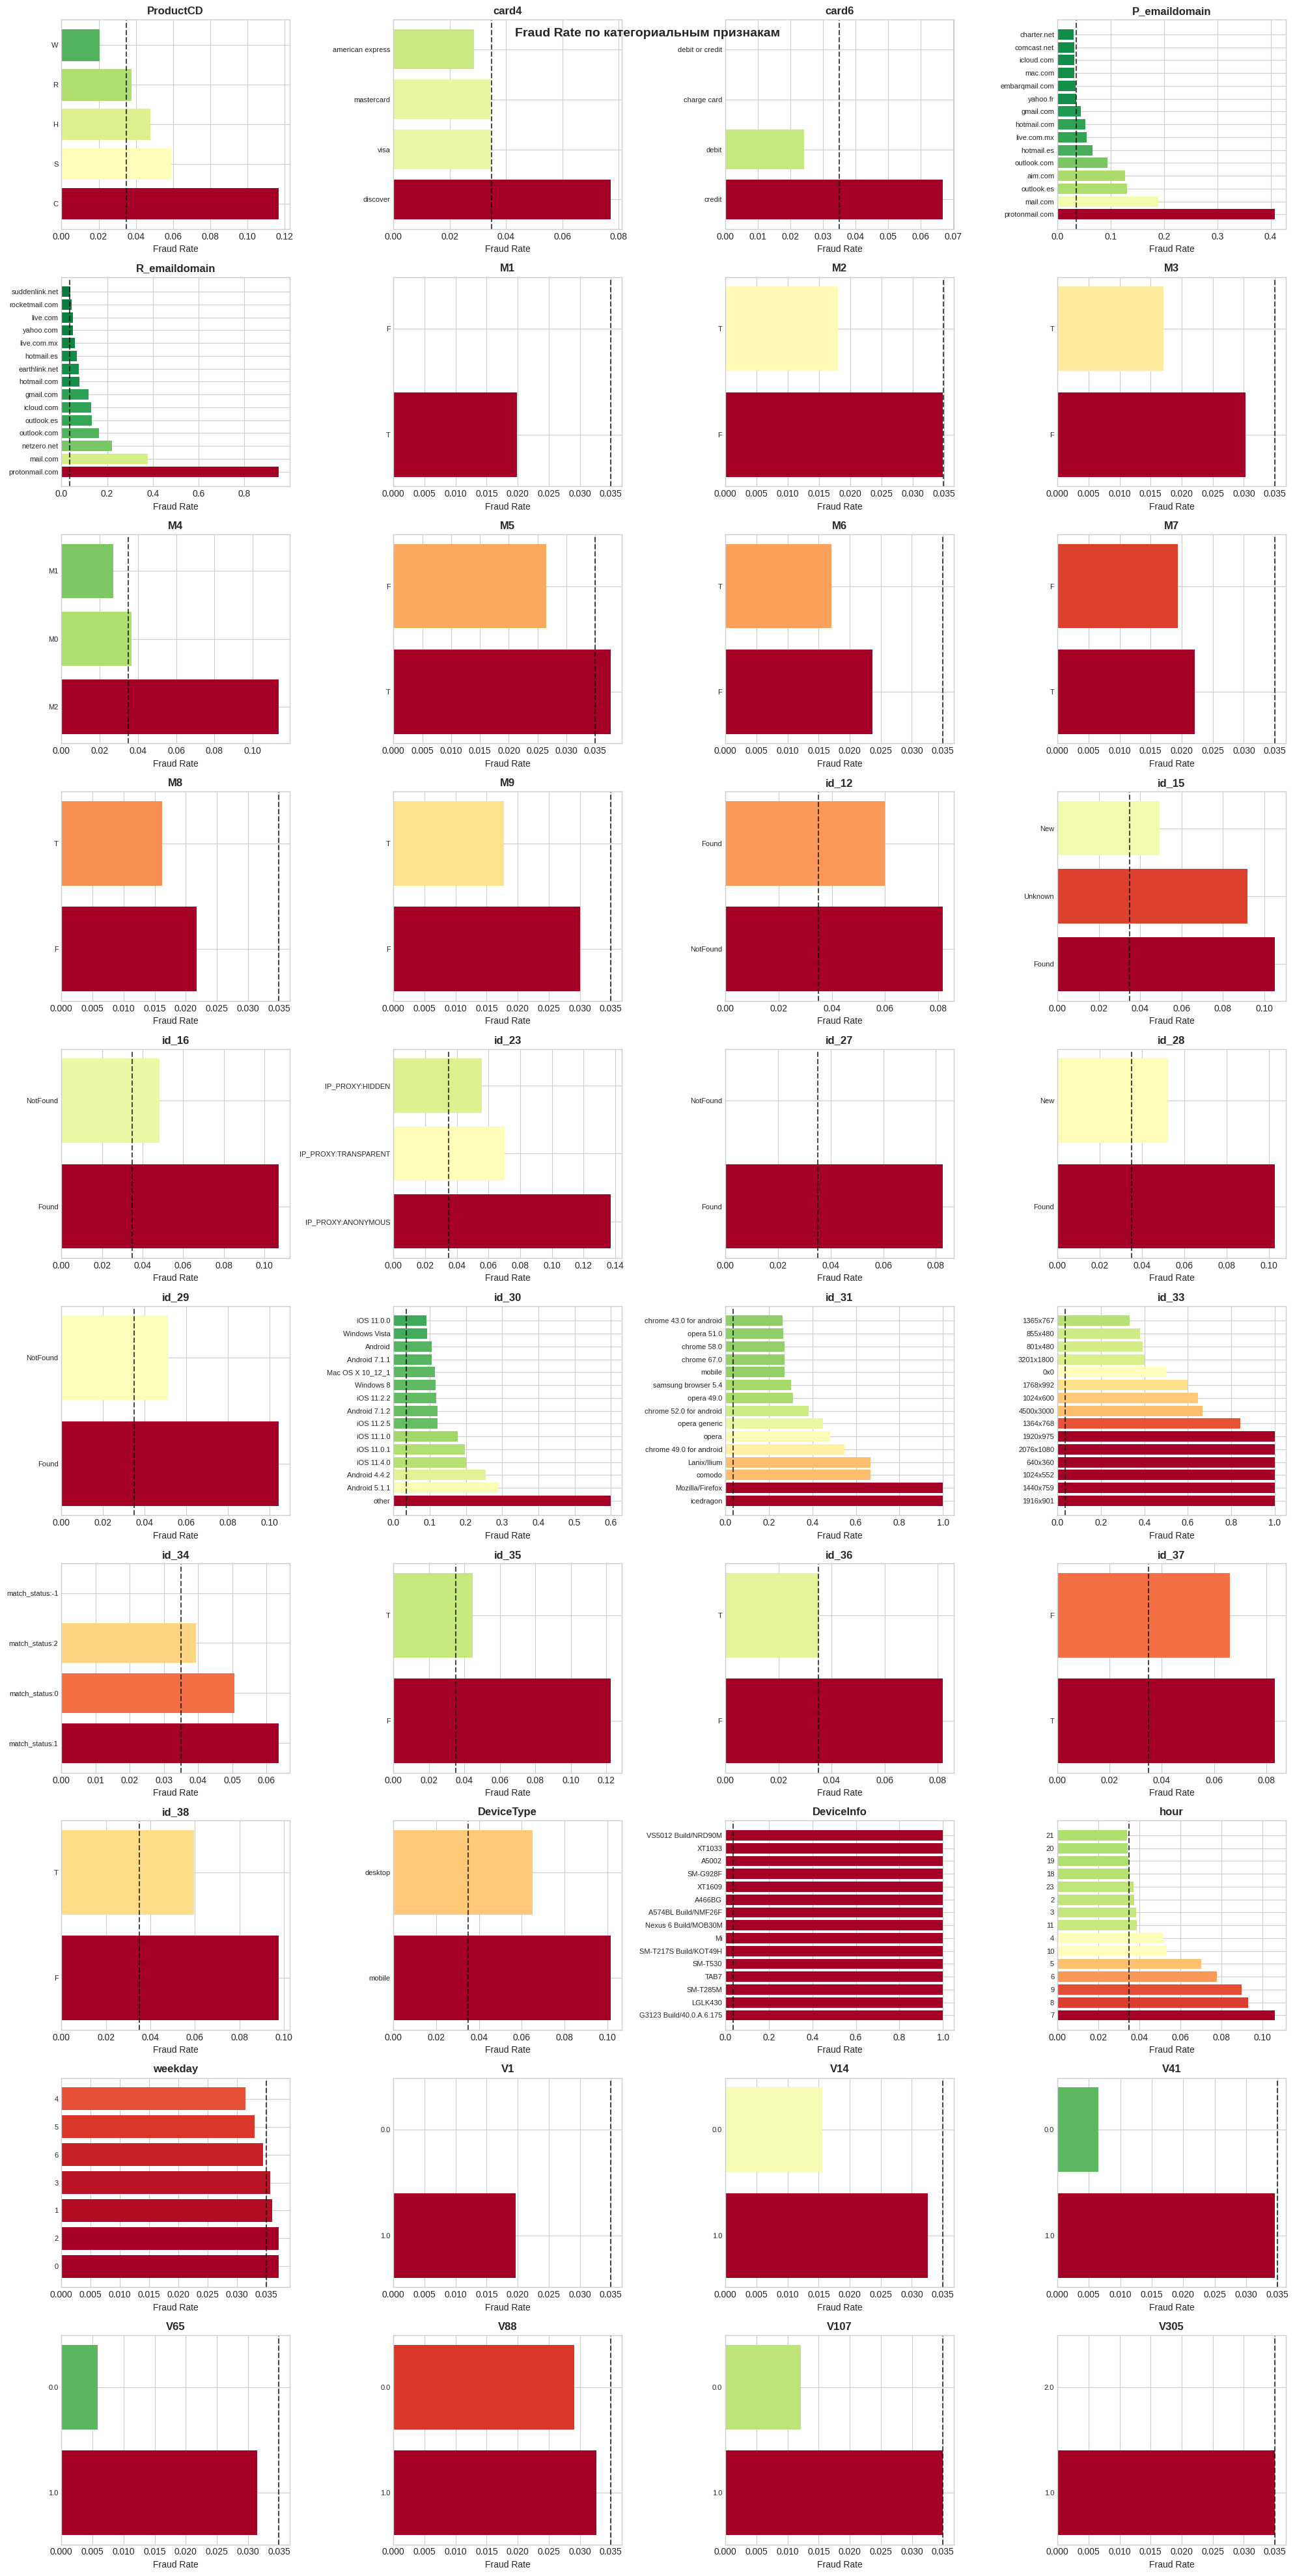

In [32]:
# Fraud rate по категориальным признакам
fig, axes = plt.subplots(10, 4, figsize=(20, 40))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    if col in train.columns:
        ax = axes[i]
        
        # Fraud rate по категориям
        fraud_by_cat = train.groupby(col)[target].agg(['mean', 'count'])
        fraud_by_cat = fraud_by_cat.sort_values('mean', ascending=False).head(15)
        
        colors = plt.cm.RdYlGn_r(fraud_by_cat['mean'] / fraud_by_cat['mean'].max())
        bars = ax.barh(range(len(fraud_by_cat)), fraud_by_cat['mean'], color=colors)
        ax.set_yticks(range(len(fraud_by_cat)))
        ax.set_yticklabels(fraud_by_cat.index, fontsize=8)
        ax.set_xlabel('Fraud Rate')
        ax.set_title(f'{col}', fontsize=12, fontweight='bold')
        ax.axvline(x=train[target].mean(), color='black', linestyle='--', alpha=0.7)

plt.suptitle('Fraud Rate по категориальным признакам', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(DATA_DIR.parent / 'reports' / 'categorical_fraud_rate.png', dpi=150, bbox_inches='tight')
plt.show()


### Анализ пропущенных значений

In [33]:
# Статистика пропусков
missing_stats = calculate_missing_stats(train)
print(f"Колонок с пропусками: {len(missing_stats)}")
print(f"Колонок без пропусков: {train.shape[1] - len(missing_stats)}")

Колонок с пропусками: 414
Колонок без пропусков: 23


In [34]:
print("Топ-20 колонок по количеству пропусков:")
print(missing_stats.head(20))

Топ-20 колонок по количеству пропусков:
   column  missing_count  missing_pct
0   id_24         585793       99.196
1   id_25         585408       99.131
2   id_08         585385       99.127
3   id_07         585385       99.127
4   id_21         585381       99.126
5   id_26         585377       99.126
6   id_23         585371       99.125
7   id_22         585371       99.125
8   id_27         585371       99.125
9   dist2         552913       93.628
10     D7         551623       93.410
11  id_18         545427       92.361
12    D13         528588       89.509
13    D14         528353       89.469
14    D12         525823       89.041
15  id_04         524216       88.769
16  id_03         524216       88.769
17     D6         517353       87.607
18  id_33         517251       87.589
19  id_09         515614       87.312


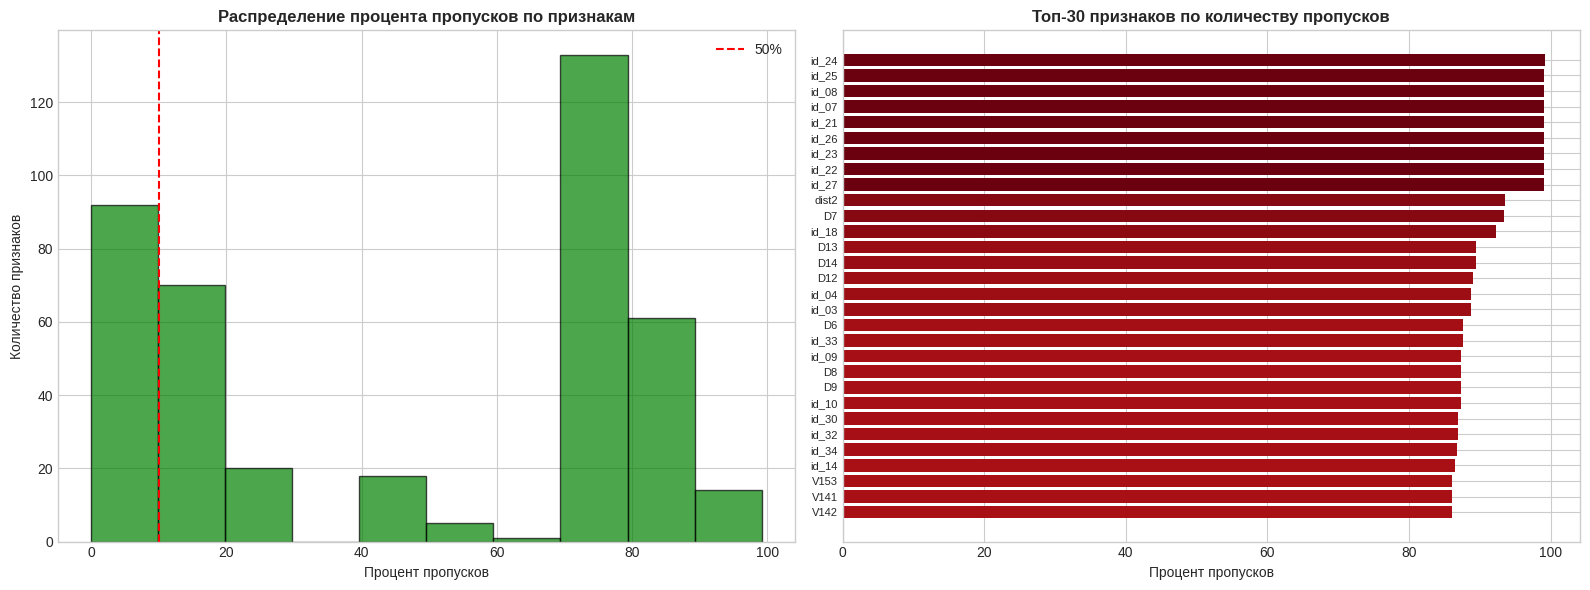

In [38]:
# Визуализация пропусков
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Гистограмма процента пропусков
ax1 = axes[0]
ax1.hist(missing_stats['missing_pct'], bins=10, color='green', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Процент пропусков')
ax1.set_ylabel('Количество признаков')
ax1.set_title('Распределение процента пропусков по признакам', fontsize=12, fontweight='bold')
ax1.axvline(x=10, color='red', linestyle='--', label='50%')
ax1.legend()

# Топ-30 признаков по пропускам
ax2 = axes[1]
top_missing = missing_stats.head(30)
colors = plt.cm.Reds(top_missing['missing_pct'] / 100)
ax2.barh(range(len(top_missing)), top_missing['missing_pct'], color=colors)
ax2.set_yticks(range(len(top_missing)))
ax2.set_yticklabels(top_missing['column'], fontsize=8)
ax2.set_xlabel('Процент пропусков')
ax2.set_title('Топ-30 признаков по количеству пропусков', fontsize=12, fontweight='bold')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig(DATA_DIR.parent / 'reports' / 'missing_values.png', dpi=150, bbox_inches='tight')
plt.show()

In [40]:
# Связь пропусков с целевой переменной
# Создадим признак количество пропусков в фичах оодного объекта
train['n_missing'] = train.isnull().sum(axis=1)

missing_fraud = train.groupby('n_missing')[target].agg(['mean', 'count'])
missing_fraud.head(20)

,mean,count
n_missing,,
24,0.000,1
26,0.000,3
27,0.000,7
28,0.000,1
29,0.000,6
30,0.000,9
31,0.000,5
32,0.000,15
33,0.000,23


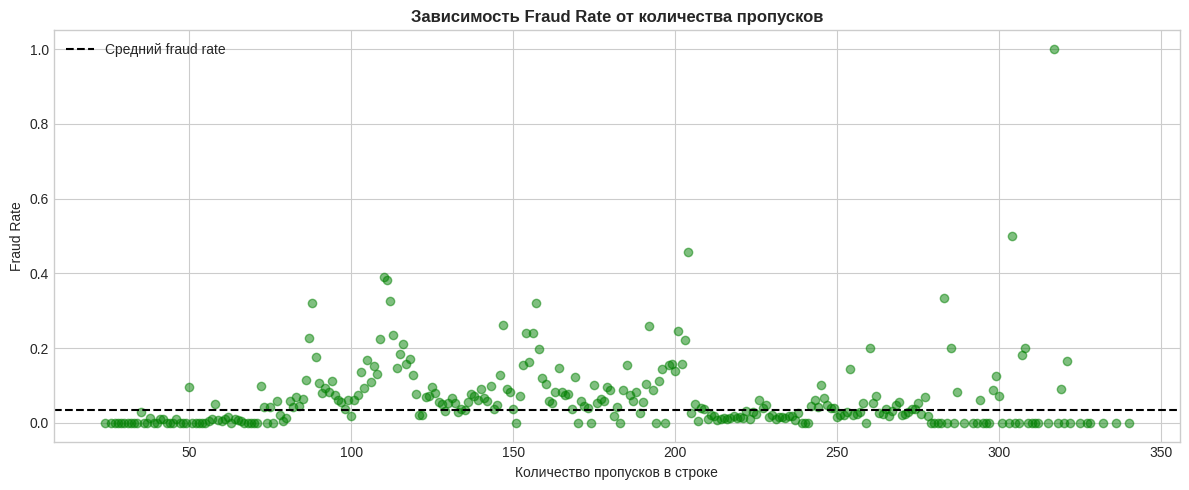

In [41]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(missing_fraud.index, missing_fraud['mean'], alpha=0.5, c='green')
ax.set_xlabel('Количество пропусков в строке')
ax.set_ylabel('Fraud Rate')
ax.set_title('Зависимость Fraud Rate от количества пропусков', fontsize=12, fontweight='bold')
ax.axhline(y=train[target].mean(), color='black', linestyle='--', label='Средний fraud rate')
ax.legend()
plt.tight_layout()
plt.savefig(DATA_DIR.parent / 'reports' / 'missing_fraud_correlation.png', dpi=150, bbox_inches='tight')
plt.show()


In [42]:
train.drop('n_missing', axis=1, inplace=True)

## Корреляционный анализ

In [43]:
# Выбираем только числовые признаки без пропусков > 50%
numeric_for_corr = [col for col in feature_types['numeric'] if train[col].isnull().mean() < 0.5]

correlations = train[numeric_for_corr + [target]].corr()[target].drop(target)
correlations = correlations.abs().sort_values(ascending=False)

print("Топ-20 признаков по корреляции с target:")
print(correlations.head(20))

Топ-20 признаков по корреляции с target:
V45   0.282
V44   0.260
V86   0.252
V87   0.252
V52   0.239
V51   0.223
V40   0.212
V39   0.203
V38   0.199
V43   0.198
V79   0.194
V42   0.189
V94   0.188
V74   0.186
V33   0.183
V17   0.183
V18   0.183
V81   0.182
V93   0.181
V92   0.181
Name: isFraud, dtype: float64


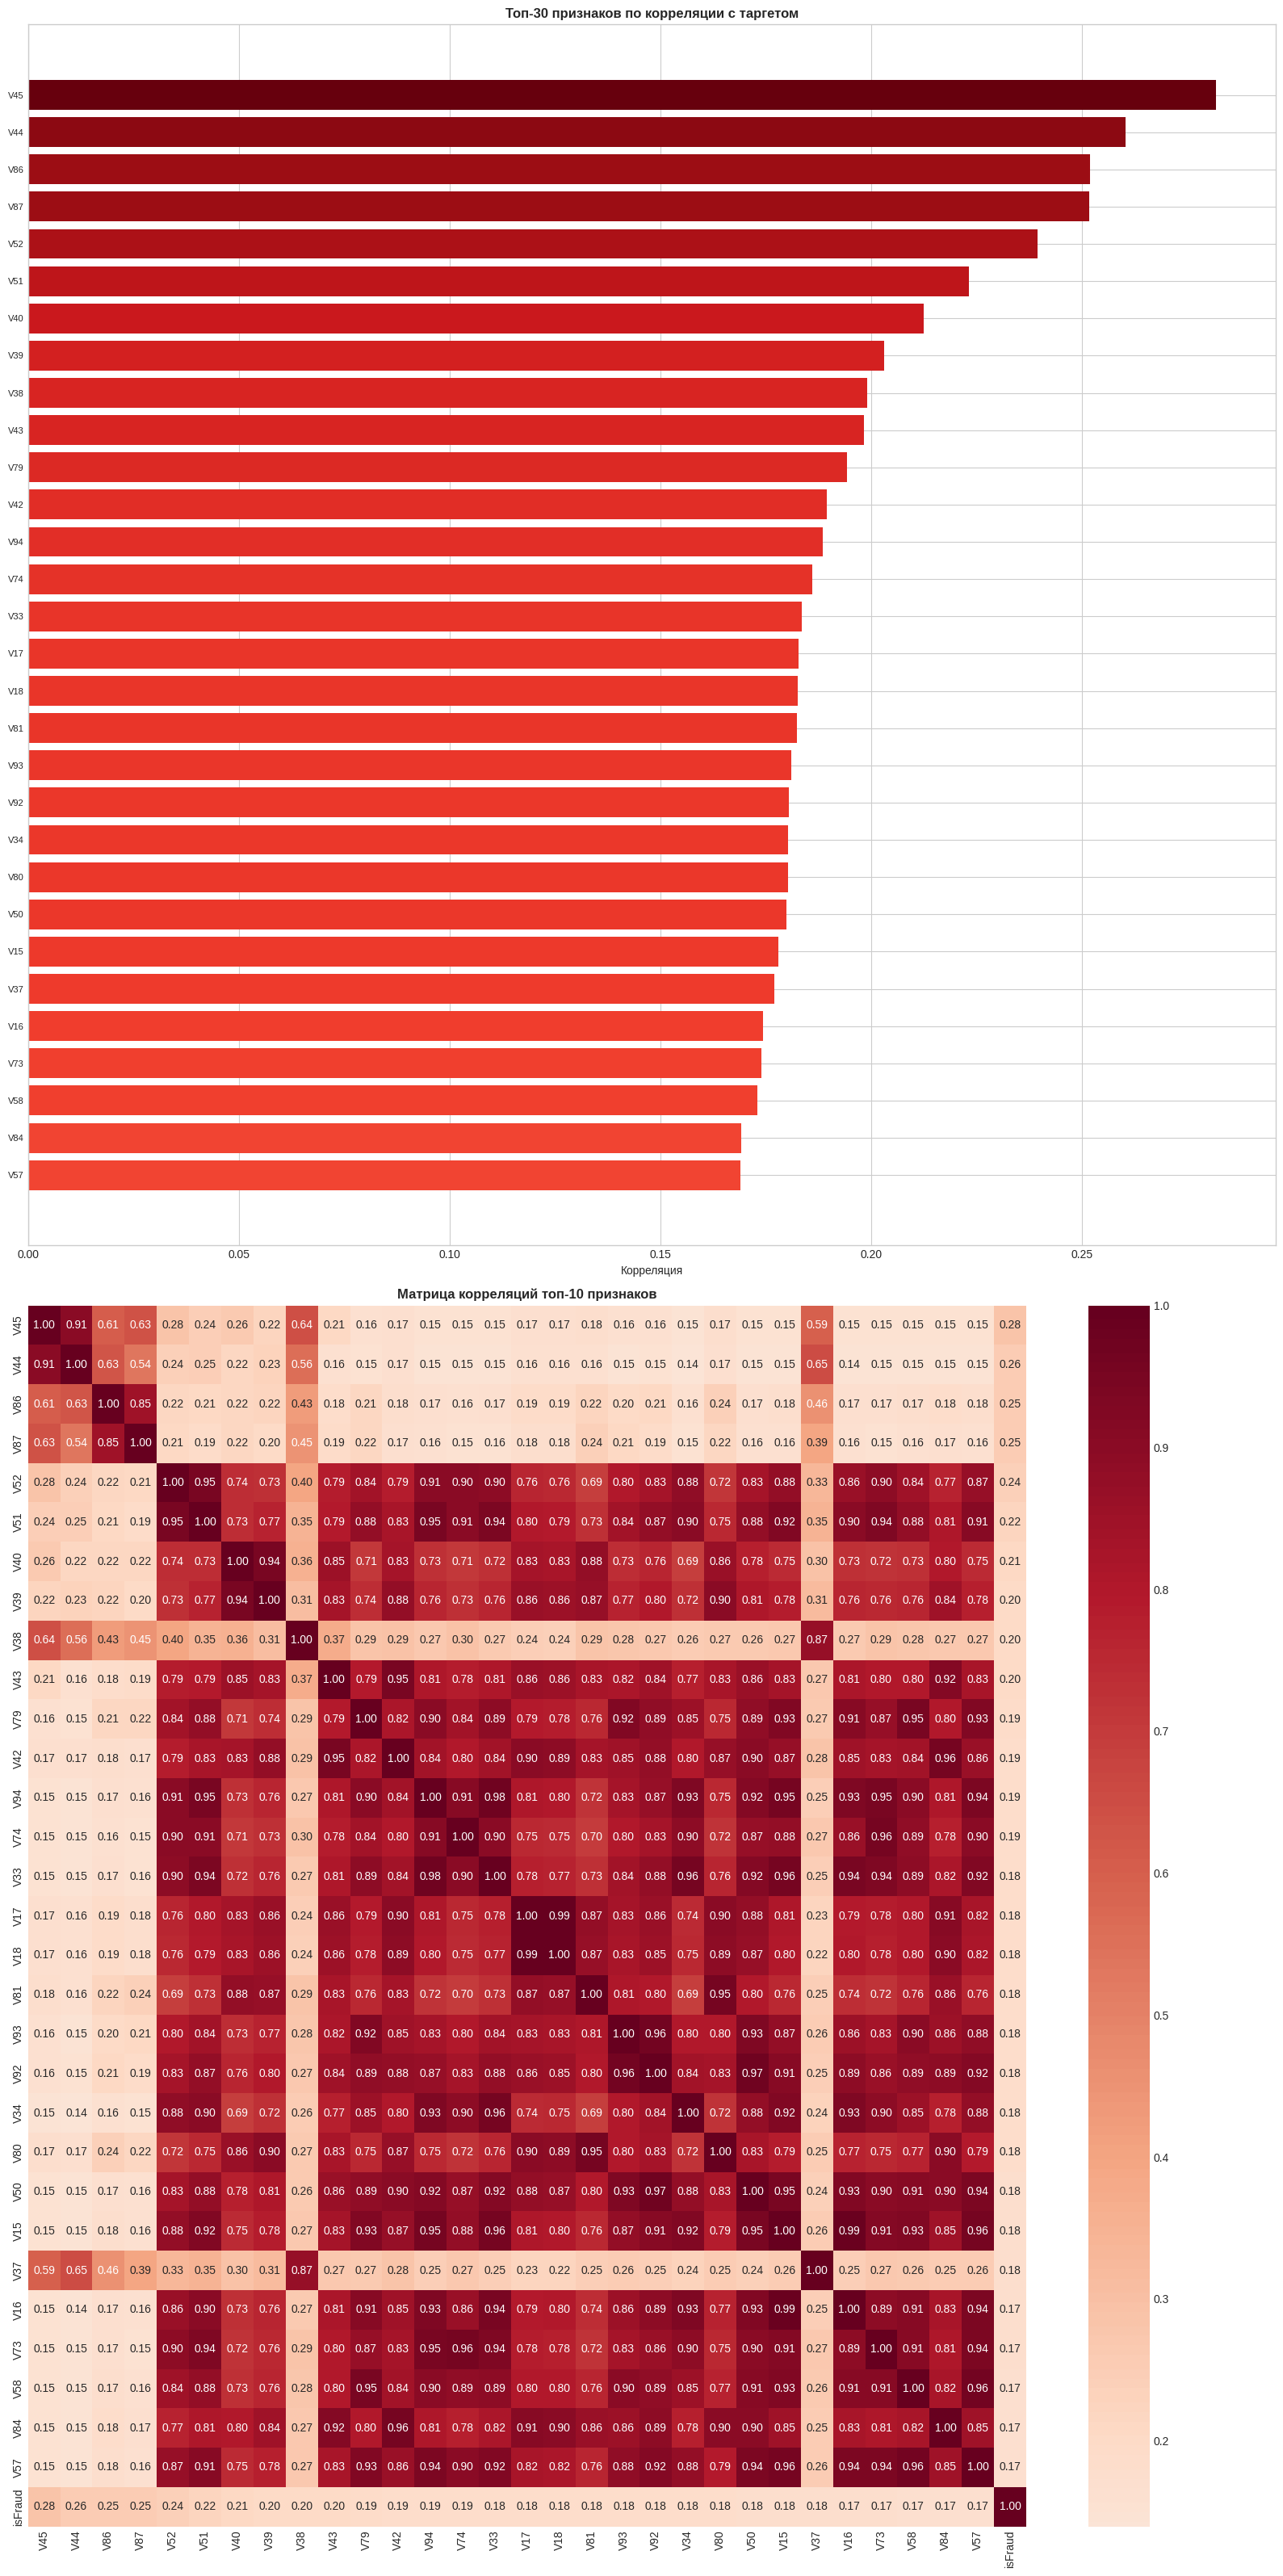

In [48]:
# Визуализация корреляций c таргетом
fig, axes = plt.subplots(2, 1, figsize=(16, 32))

# Топ-20 по корреляции
ax1 = axes[0]
top_corr = correlations.head(30)
colors = plt.cm.Reds(top_corr.values / top_corr.max())
ax1.barh(range(len(top_corr)), top_corr.values, color=colors)
ax1.set_yticks(range(len(top_corr)))
ax1.set_yticklabels(top_corr.index, fontsize=8)
ax1.set_xlabel('Корреляция')
ax1.set_title('Топ-30 признаков по корреляции с таргетом', fontsize=12, fontweight='bold')
ax1.invert_yaxis()

# Матрица корреляций топ признаков
ax2 = axes[1]
top_features = correlations.head(30).index.tolist() + [target]
corr_matrix = train[top_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax2)
ax2.set_title('Матрица корреляций топ-10 признаков', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(DATA_DIR.parent / 'reports' / 'correlations.png', dpi=150, bbox_inches='tight')
plt.show()

Как видно, ряд признаков довольно сильно коррелируют - как V51 и V52 или V50 и V15, что будет в будущем необходимо учесть при решении задачи

### Выявление аномалий

In [50]:
# Автоматический поиск выбросов во всех числовых признаках
# Определение выбросов по методу IQR
def detect_outliers_iqr(series: pd.Series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return (series < lower) | (series > upper)

numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in [target, 'TransactionID']]

outlier_stats = []

for col in numeric_cols:
    # Пропускаем колонки с 50% пропусков и больше
    if train[col].isnull().mean() > 0.5:
        continue
    
    # Зпихаем в NaN медиану
    col_filled = train[col].fillna(train[col].median())
    
    outliers_mask = detect_outliers_iqr(col_filled)
    outlier_pct = outliers_mask.mean() * 100
    
    if outlier_pct == 0:
        continue
    
    fraud_rate_outliers = train.loc[outliers_mask, target].mean() * 100
    fraud_rate_normal = train.loc[~outliers_mask, target].mean() * 100
    fraud_rate_diff = fraud_rate_outliers - fraud_rate_normal
    
    outlier_stats.append({
        'feature': col,
        'outlier_pct': outlier_pct,
        'outlier_count': outliers_mask.sum(),
        'fraud_rate_outliers': fraud_rate_outliers,
        'fraud_rate_normal': fraud_rate_normal,
        'fraud_rate_diff': fraud_rate_diff,
        'abs_fraud_diff': abs(fraud_rate_diff)
    })

outlier_df = pd.DataFrame(outlier_stats)
outlier_df = outlier_df.sort_values('abs_fraud_diff', ascending=False)

print(f"Проанализировано признаков: {len(outlier_df)}")
print(f"Признаков с значимыми выбросами: {len(outlier_df[outlier_df['abs_fraud_diff'] > 0.5])}")

Проанализировано признаков: 205
Признаков с значимыми выбросами: 188


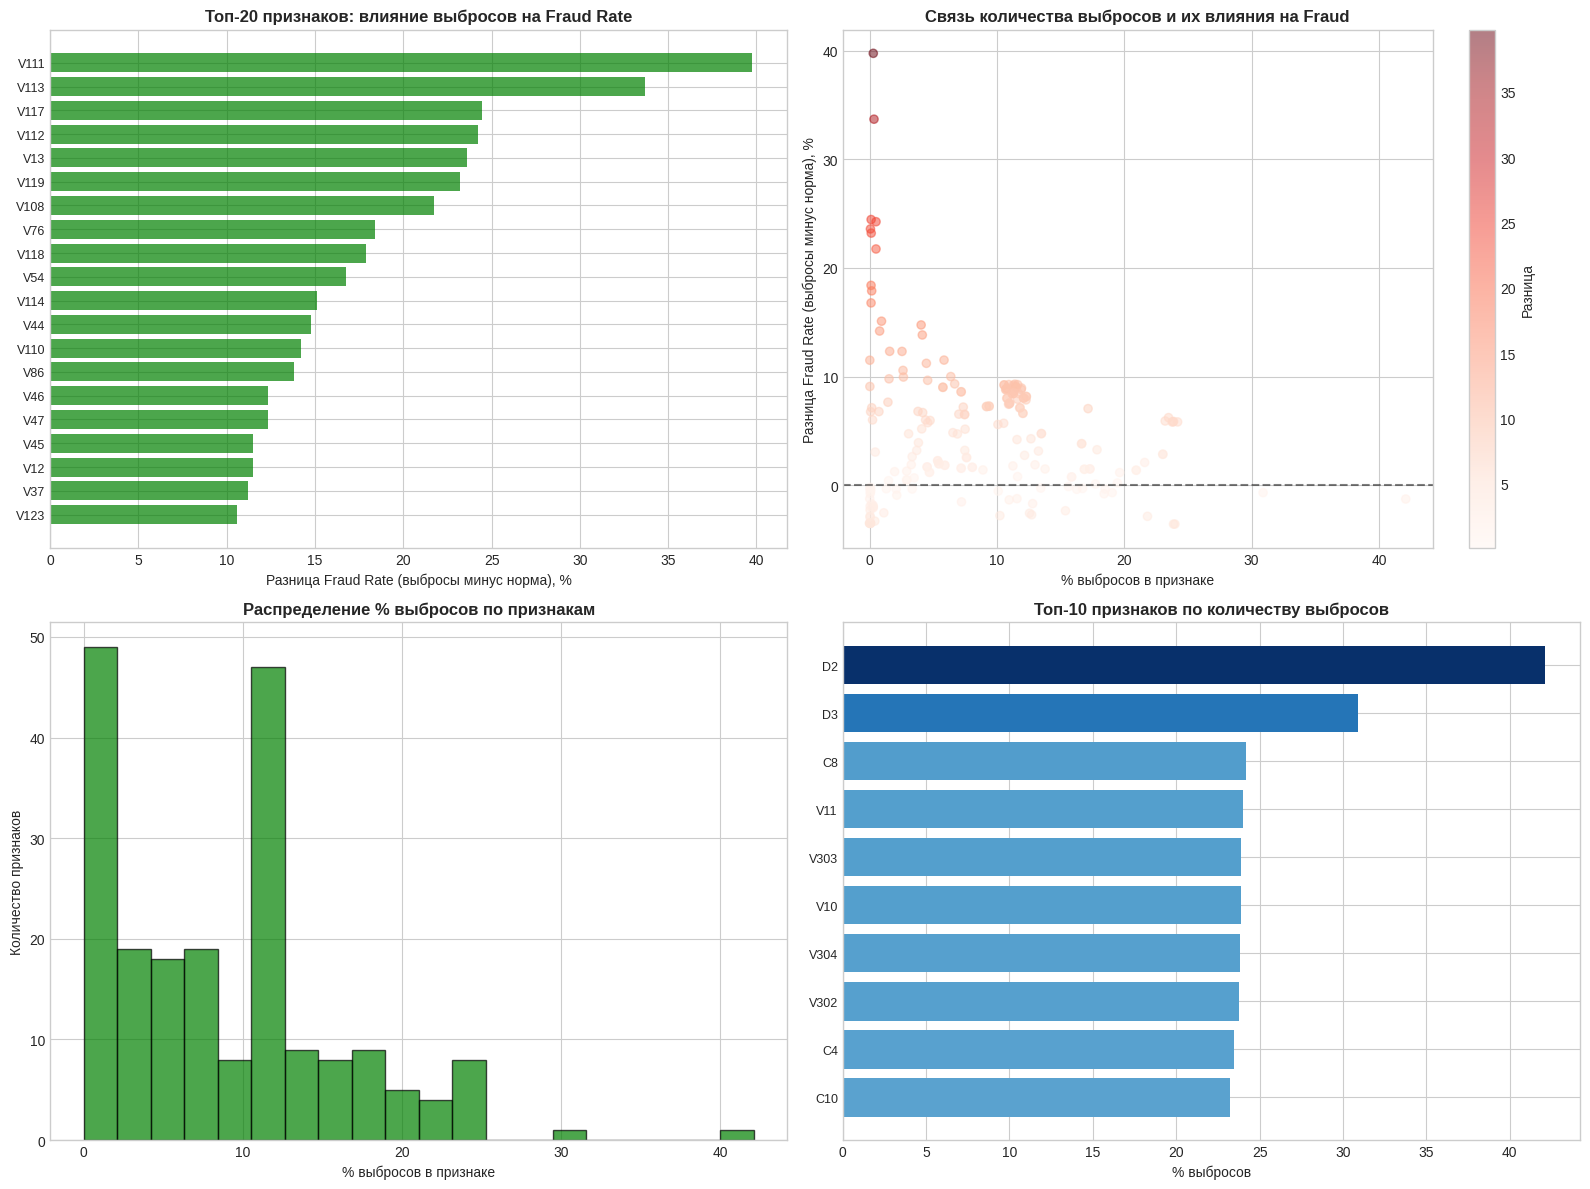

In [55]:
# Визуализация топ-30 признаков с аномалиями
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Нарисуем разницы fraud rate
ax1 = axes[0, 0]
top20 = outlier_df.head(20)
bars = ax1.barh(range(len(top20)), top20['fraud_rate_diff'], color=["green"], alpha=0.7)
ax1.set_yticks(range(len(top20)))
ax1.set_yticklabels(top20['feature'], fontsize=9)
ax1.set_xlabel('Разница Fraud Rate (выбросы минус норма), %')
ax1.set_title('Топ-20 признаков: влияние выбросов на Fraud Rate', fontsize=12, fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax1.invert_yaxis()

# % выбросов vs разница fraud rate
ax2 = axes[0, 1]
scatter = ax2.scatter(
    outlier_df['outlier_pct'], outlier_df['fraud_rate_diff'], 
    c=outlier_df['abs_fraud_diff'], cmap='Reds', alpha=0.5
)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel('% выбросов в признаке')
ax2.set_ylabel('Разница Fraud Rate (выбросы минус норма), %')
ax2.set_title('Связь количества выбросов и их влияния на Fraud', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax2, label='Разница')

# Распределение % выбросов по признакам
ax3 = axes[1, 0]
ax3.hist(outlier_df['outlier_pct'], bins=20, color='green', edgecolor='black', alpha=0.7)
ax3.set_xlabel('% выбросов в признаке')
ax3.set_ylabel('Количество признаков')
ax3.set_title('Распределение % выбросов по признакам', fontsize=12, fontweight='bold')
ax3.legend()

# Топ-10 признаков с наибольшим % выбросов
ax4 = axes[1, 1]
top10_by_pct = outlier_df.nlargest(10, 'outlier_pct')
colors = plt.cm.Blues(top10_by_pct['outlier_pct'] / top10_by_pct['outlier_pct'].max())
ax4.barh(range(len(top10_by_pct)), top10_by_pct['outlier_pct'], color=colors)
ax4.set_yticks(range(len(top10_by_pct)))
ax4.set_yticklabels(top10_by_pct['feature'], fontsize=9)
ax4.set_xlabel('% выбросов')
ax4.set_title('Топ-10 признаков по количеству выбросов', fontsize=12, fontweight='bold')
ax4.invert_yaxis()

plt.tight_layout()
plt.savefig(DATA_DIR.parent / 'reports' / 'outliers_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

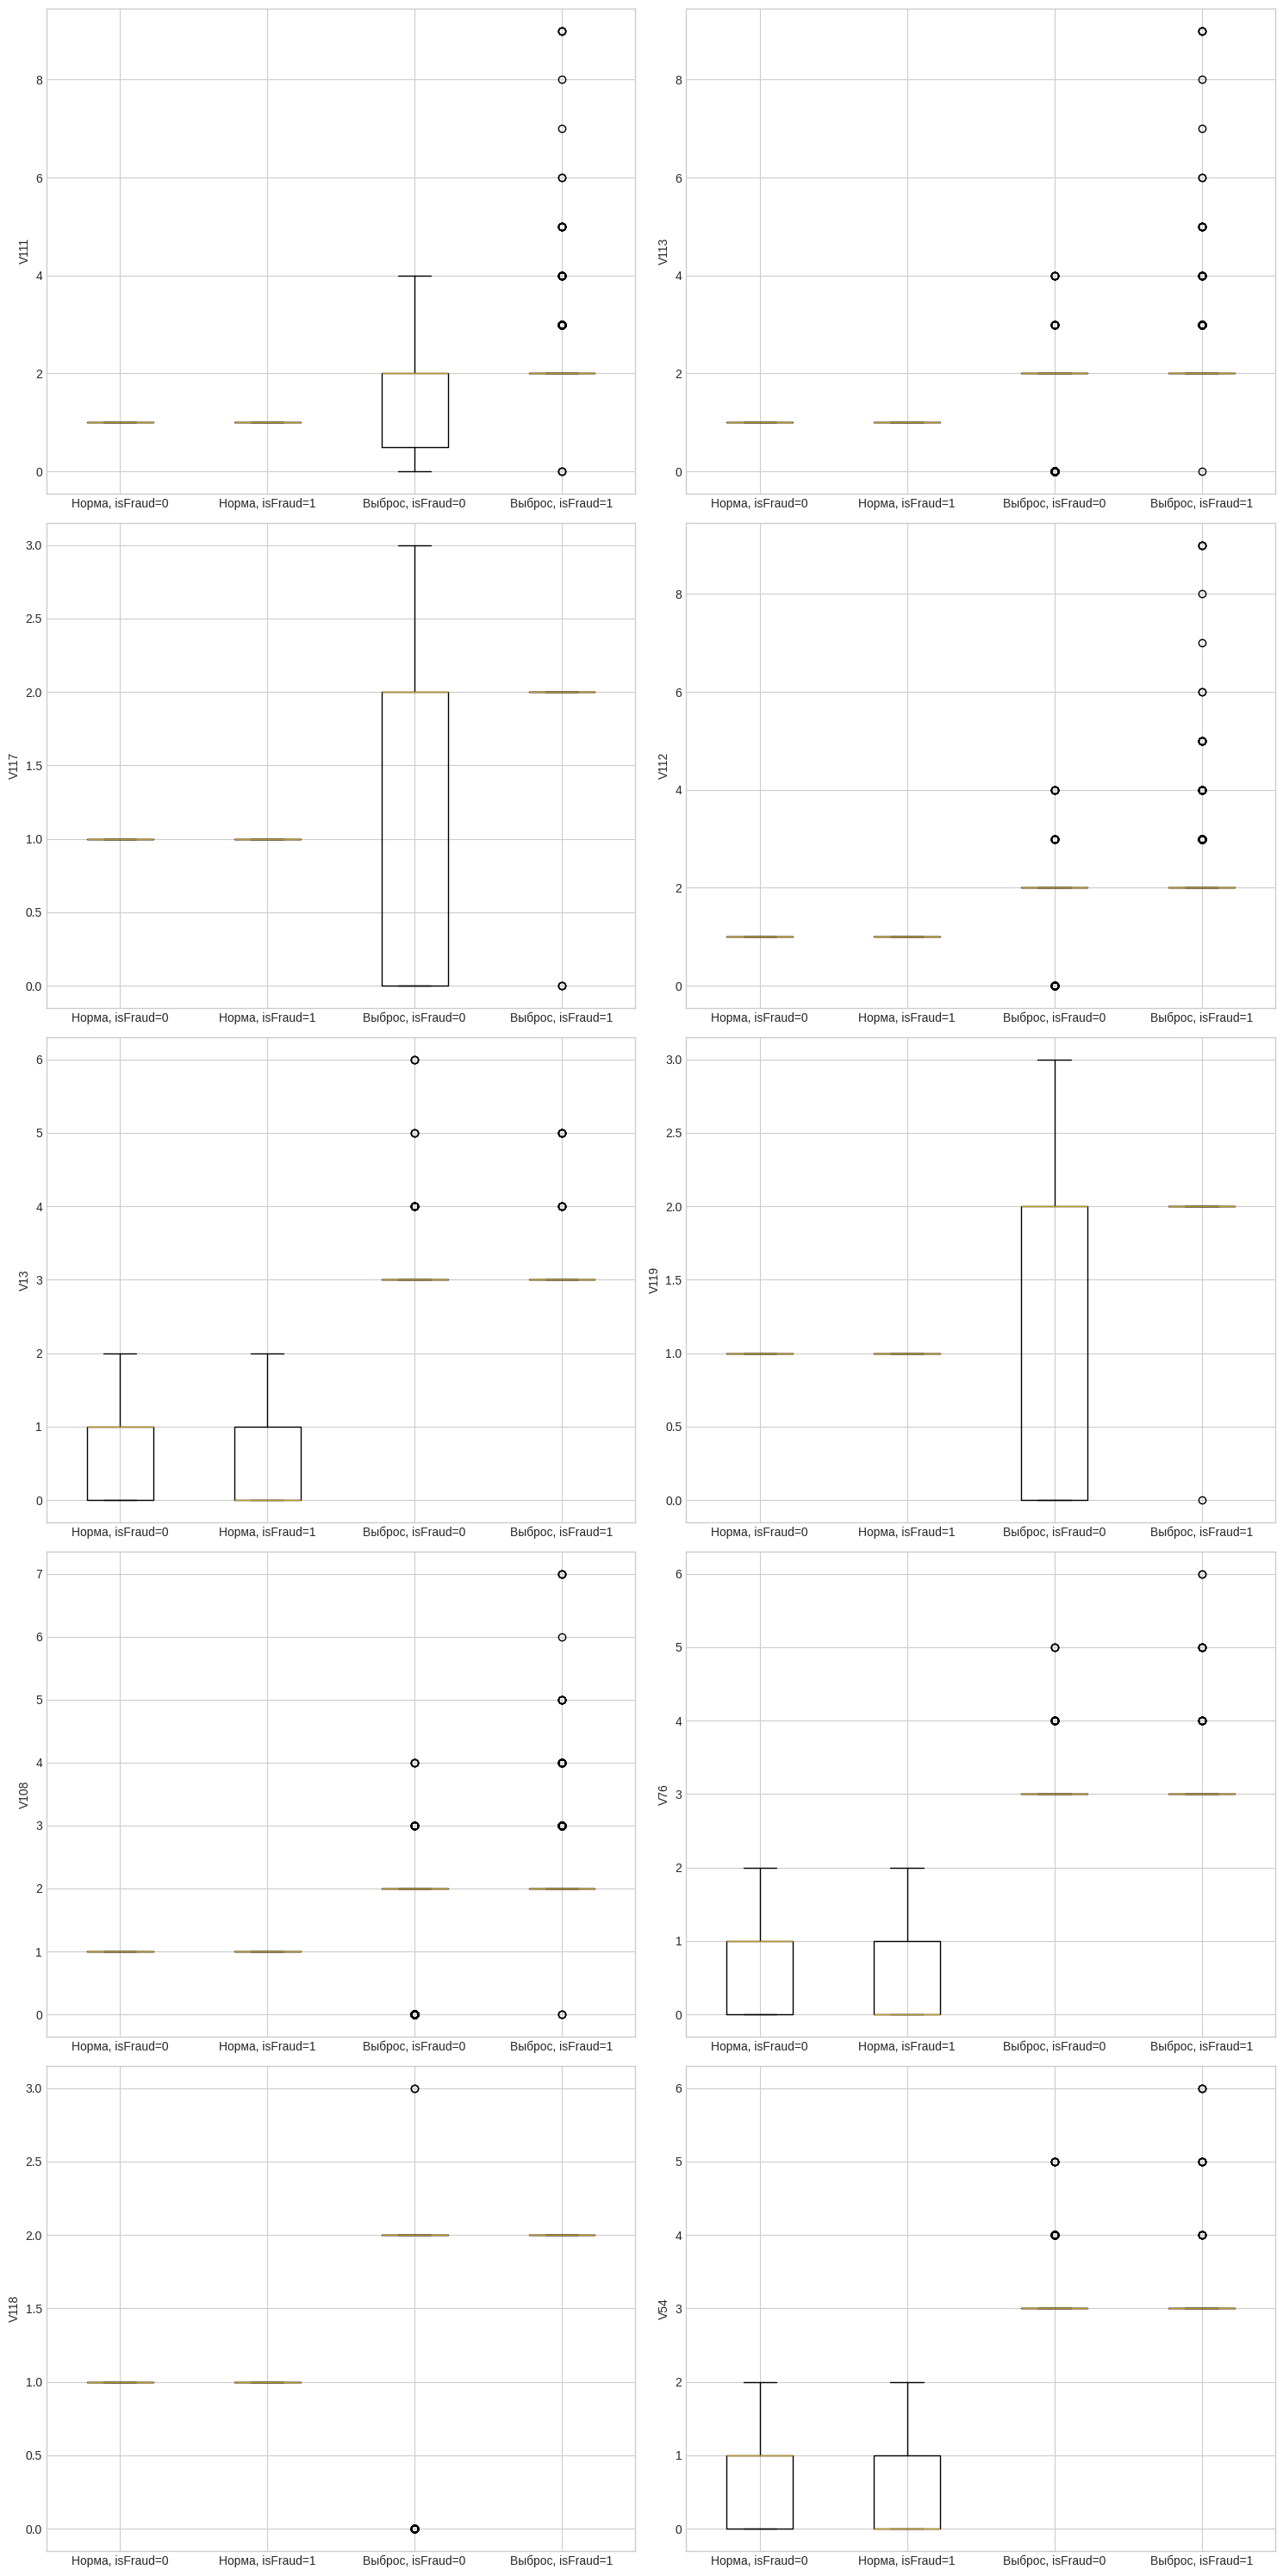

In [61]:
# И пусть тут будет еще анализ топ 10 признаков с выбросами
fig, axes = plt.subplots(5, 2, figsize=(15, 30))
axes = axes.flatten()

top_features = outlier_df.head(10)['feature'].tolist()

for i, col in enumerate(top_features):
    ax = axes[i]
    
    col_data = train[col].fillna(train[col].median())
    outliers_mask = detect_outliers_iqr(col_data)
    
    data_to_plot = [
        train.loc[(~outliers_mask) & (train[target] == 0), col].dropna(),
        train.loc[(~outliers_mask) & (train[target] == 1), col].dropna(),
        train.loc[(outliers_mask) & (train[target] == 0), col].dropna(),
        train.loc[(outliers_mask) & (train[target] == 1), col].dropna()
    ]
    
    bp = ax.boxplot(data_to_plot, labels=[
        'Норма, isFraud=0', 'Норма, isFraud=1', 
        'Выброс, isFraud=0', 'Выброс, isFraud=1'
    ])

    outlier_info = outlier_df[outlier_df['feature'] == col].iloc[0]
    ax.set_ylabel(col)

plt.tight_layout()
plt.savefig(DATA_DIR.parent / 'reports' / 'outliers_detailed.png', dpi=150, bbox_inches='tight')
plt.show()

In [66]:
conclusions = f"""
Признаки с наибольшим влиянием выбросов на fraud:
   - {outlier_df.iloc[0]['feature']}: = {outlier_df.iloc[0]['fraud_rate_diff']:+.2f}%
   - {outlier_df.iloc[1]['feature']}: = {outlier_df.iloc[1]['fraud_rate_diff']:+.2f}%
   - {outlier_df.iloc[2]['feature']}: = {outlier_df.iloc[2]['fraud_rate_diff']:+.2f}%

Признаки где выбросы приводят к повышенному fraud:
   {len(outlier_df[outlier_df['fraud_rate_diff'] > 0.5])} признаков

Признаки где выбросы приводят к пониженному fraud:
   {len(outlier_df[outlier_df['fraud_rate_diff'] < -0.5])} признаков
"""
print(conclusions)


Признаки с наибольшим влиянием выбросов на fraud:
   - V111: = +39.76%
   - V113: = +33.69%
   - V117: = +24.45%

Признаки где выбросы приводят к повышенному fraud:
   152 признаков

Признаки где выбросы приводят к пониженному fraud:
   36 признаков



## Гипотезы по Feature Engineering

**Гипотеза: Комбинация card1 + addr1 идентифицирует пользователя.**

Мошенники часто используют одни и те же карты или адреса многократно за короткий период. Создание ID пользователя позволит агрегировать информацию о его поведении и выявлять аномалии.

**Гипотеза: D1 - это количество дней с первого использования карты.**

Согласно описанию данных, D-признаки представляют собой timedelta-значения. Если D1 = количество дней с первой транзакции по карте, то TransactionDT/86400 - D1 даёт дату первого использования карты. Нормализация приводит D-признаки к единому масштабу для разных пользователей.

**Гипотеза: Мошенничество имеет временные паттерны.**

Из EDA видно, что fraud rate различается в зависимости от времени суток.

**Гипотеза: Статистики транзакций внутри группы (карта, адрес, email) могут пригодиться.**

Агрегации создают что-то вроде профиля каждой группы. Отклонение от профиля - сигнал аномалии. 

**Гипотеза: Редкие значения категориальных признаков чаще связаны с мошенничеством.**

Мошенники могут использовать нетипичные устройства, редкие email-домены или что-то еще такое.

**Гипотеза: Домен email говорит о надёжности пользователя.**

Из EDA видно, что некоторые email-домены имеют fraud rate значительно выше среднего. 

**Гипотеза: Количество пропусков в записи коррелирует с мошенничеством.**

Из анализа пропусков видно, что транзакции без identity-данных могут иметь другой fraud rate. Мошенники могут скрывать информацию о себе.

**Гипотеза: Комбинации признаков могут быть более информативны, чем отдельные признаки.**

Накидаем примеров:
- отношение суммы к средней по карте
- логарифм суммы
- дробная часть суммы (мошенники часто используют круглые суммы)
- отношение C1 к C2
- сумма / количество транзакций пользователя